# Imports and constants

In [180]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

url_pattern = re.compile(r'https?://\S+|www\.\S+')
technical_terms = ['parse', 'print', 'debug', 'exception', 'error', 'warning']


# Tokenize the text 

In [181]:
def process_text(text):
    text_without_url = url_pattern.sub(r'', text)
    tokens = word_tokenize(text_without_url)
    # remove punctuation
    cleaned_tokens = [token for token in tokens if token.isalpha()]

    lemmatizer = WordNetLemmatizer()
    lemmatizer_tokens = [lemmatizer.lemmatize(token.lower()) for token in cleaned_tokens]

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in lemmatizer_tokens if token not in stop_words]

    return ' '.join(filtered_tokens)

# Extract url from the text

In [182]:
def extract_url(text):
    urls = url_pattern.findall(text)
    
    cleaned_url = [url.rstrip('\'".,;])') for url in urls]  
    return cleaned_url

# Process the text and save it in a new location

In [183]:
input_dir = 'documentation'
output_dir = 'processedDocumentation'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

files_dictionary = {}
map_created = False


for root, dirs, files in os.walk(input_dir):
    if not map_created:
        map_created = True
        for dir in dirs:
            files_dictionary[dir] = []
    urls = []
   
    for file in files:
        if file.endswith('.txt'):
            input_file_path = os.path.join(root, file)
            output_file_path = input_file_path.replace(input_dir, output_dir)

            output_folder = os.path.dirname(output_file_path)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            with open(input_file_path, 'r', encoding='utf-8') as input_file:
                text = input_file.read()
                processed_text = process_text(text)

                with open(output_file_path, 'w', encoding='utf-8') as output_file:
                    output_file.write(processed_text)
            urls.append(extract_url(text))
            files_dictionary[root.split("\\")[1]].append(file)
    if urls:
        output_file_url = os.path.join(root.replace(input_dir, output_dir), 'urls.txt')
        with open(output_file_url, 'w', encoding='utf-8') as output_file:
            for urls_child in urls:
                for url in urls_child:
                    output_file.write(str(url) + '\n')
                    
        # files_dictionary[root.split("\\")[1]].append("url.txt")
# print(files_dictionary)


# Read the processed text

In [184]:
def read_processed_file(location):
    content = []
    with open(location, 'r', encoding='utf-8') as file:
        content.append(file.read())
    return ' '.join(content)

def read_processed_folder(directory, files):
    content = []
    for file in files:
        location = os.path.join("processedDocumentation", directory, file)
        content.append(read_processed_file(location))
    return ' '.join(content)

# Readme cosine similarity

In [185]:
readmes = [read_processed_file("processedDocumentation\\" + folder + "\\readme.txt") for folder in files_dictionary.keys()]
# print(readmes)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_readme = tfidf_vectorizer.fit_transform(readmes)

num_docs_readme = len(readmes)
# print(num_docs)

similarities_readme = [[0 for _ in range(num_docs_readme)] for _ in range(num_docs_readme)]

for i in range(num_docs_readme):
    for j in range(num_docs_readme):
        similarities_readme[i][j] = cosine_similarity(tfidf_matrix_readme[i], tfidf_matrix_readme[j])[0][0]


for i in range(num_docs_readme):
    for j in range(num_docs_readme):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_readme[i][j]) 

github-api-hub4j github-api-hub4j old 1.0
github-api-hub4j haskell-exercism 0.025762714290229607
github-api-hub4j Java-joeyajames 0.033378429031517214
github-api-hub4j minecolonies-ldtteam 0.03453386861127865
github-api-hub4j old haskell-exercism 0.025762714290229607
github-api-hub4j old Java-joeyajames 0.033378429031517214
github-api-hub4j old minecolonies-ldtteam 0.03453386861127865
haskell-exercism Java-joeyajames 0.044883776196674254
haskell-exercism minecolonies-ldtteam 0.12049721894325831
Java-joeyajames minecolonies-ldtteam 0.03816017129667453


# Wiki cosine similarity

In [186]:
wikis = [read_processed_file("processedDocumentation\\" + folder + "\\wiki.txt") if 'wiki.txt' in files_dictionary[folder] else '' for folder in files_dictionary.keys()]
# print(wikis)

# tfidf_vectorizer_wiki = TfidfVectorizer()
tfidf_matrix_wiki = tfidf_vectorizer.fit_transform(wikis)

num_docs_wiki = len(wikis)
# print(num_docs)

similarities_wiki = [[0 for _ in range(num_docs_wiki)] for _ in range(num_docs_wiki)]

for i in range(num_docs_wiki):
    for j in range(num_docs_wiki):
        similarities_wiki[i][j] = cosine_similarity(tfidf_matrix_wiki[i], tfidf_matrix_wiki[j])[0][0]


for i in range(num_docs_wiki):
    for j in range(num_docs_wiki):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_wiki[i][j]) 

github-api-hub4j github-api-hub4j old 0.9186830750117152
github-api-hub4j haskell-exercism 0.0
github-api-hub4j Java-joeyajames 0.0
github-api-hub4j minecolonies-ldtteam 0.12165131352049659
github-api-hub4j old haskell-exercism 0.0
github-api-hub4j old Java-joeyajames 0.0
github-api-hub4j old minecolonies-ldtteam 0.12693396605274937
haskell-exercism Java-joeyajames 0.0
haskell-exercism minecolonies-ldtteam 0.0
Java-joeyajames minecolonies-ldtteam 0.0


# Comments cosine similarity

In [187]:
comments = [read_processed_file("processedDocumentation\\" + folder + "\\comments.txt") if 'wiki.txt' in files_dictionary[folder] else '' for folder in files_dictionary.keys()]
# print(wikis)

# tfidf_vectorizer_wiki = TfidfVectorizer()
tfidf_matrix_comm = tfidf_vectorizer.fit_transform(comments)

num_docs_comm = len(comments)
# print(num_docs)

similarities_comments = [[0 for _ in range(num_docs_comm)] for _ in range(num_docs_comm)]

for i in range(num_docs_comm):
    for j in range(num_docs_comm):
        similarities_comments[i][j] = cosine_similarity(tfidf_matrix_comm[i], tfidf_matrix_comm[j])[0][0]


for i in range(num_docs_comm):
    for j in range(num_docs_comm):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_comments[i][j]) 

github-api-hub4j github-api-hub4j old 1.0000000000000004
github-api-hub4j haskell-exercism 0.0
github-api-hub4j Java-joeyajames 0.0
github-api-hub4j minecolonies-ldtteam 0.567020086133195
github-api-hub4j old haskell-exercism 0.0
github-api-hub4j old Java-joeyajames 0.0
github-api-hub4j old minecolonies-ldtteam 0.567020086133195
haskell-exercism Java-joeyajames 0.0
haskell-exercism minecolonies-ldtteam 0.0
Java-joeyajames minecolonies-ldtteam 0.0


# Combined cosine similarity

In [188]:
combined = [read_processed_folder(folder, files_dictionary[folder]) for folder in files_dictionary.keys()]

tfidf_matrix_comm = tfidf_vectorizer.fit_transform(combined)

num_docs_combined = len(combined)
# print(num_docs)

similarities_combined = [[0 for _ in range(num_docs_combined)] for _ in range(num_docs_combined)]

for i in range(num_docs_combined):
    for j in range(num_docs_combined):
        similarities_combined[i][j] = cosine_similarity(tfidf_matrix_comm[i], tfidf_matrix_comm[j])[0][0]


for i in range(num_docs_combined):
    for j in range(num_docs_combined):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_combined[i][j]) 

github-api-hub4j github-api-hub4j old 0.9999681275047855
github-api-hub4j haskell-exercism 0.14393493005043123
github-api-hub4j Java-joeyajames 0.06777664034467741
github-api-hub4j minecolonies-ldtteam 0.5186851455416999
github-api-hub4j old haskell-exercism 0.14431195412228545
github-api-hub4j old Java-joeyajames 0.06778411851857961
github-api-hub4j old minecolonies-ldtteam 0.5186082057076223
haskell-exercism Java-joeyajames 0.07467434467914595
haskell-exercism minecolonies-ldtteam 0.11063773975733543
Java-joeyajames minecolonies-ldtteam 0.057289462767452705


# Data visualization

## Heatmap

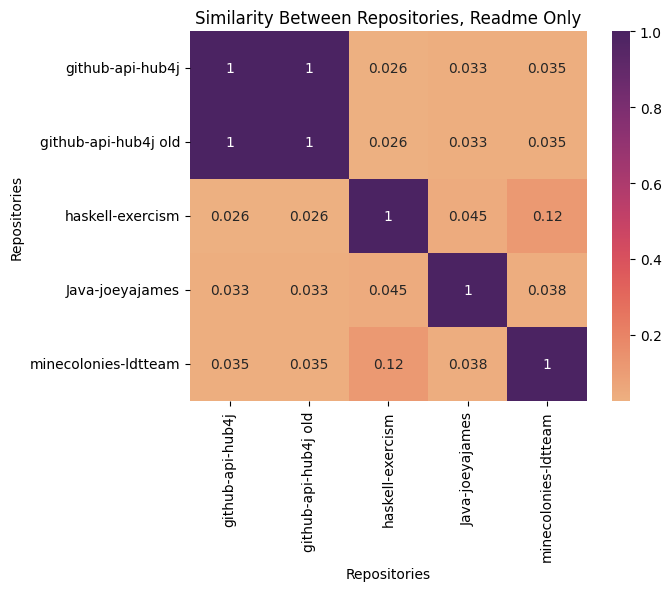

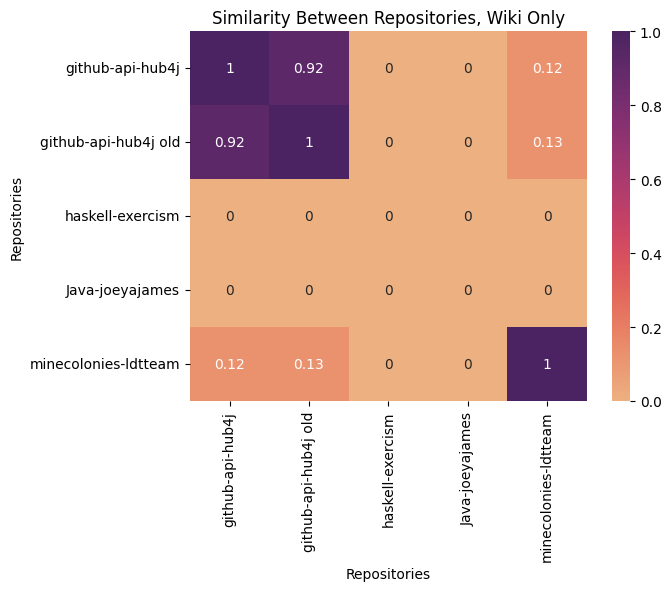

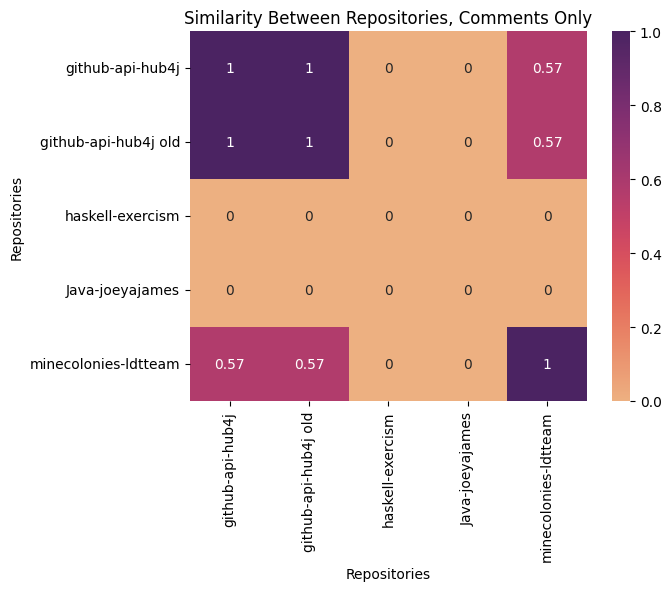

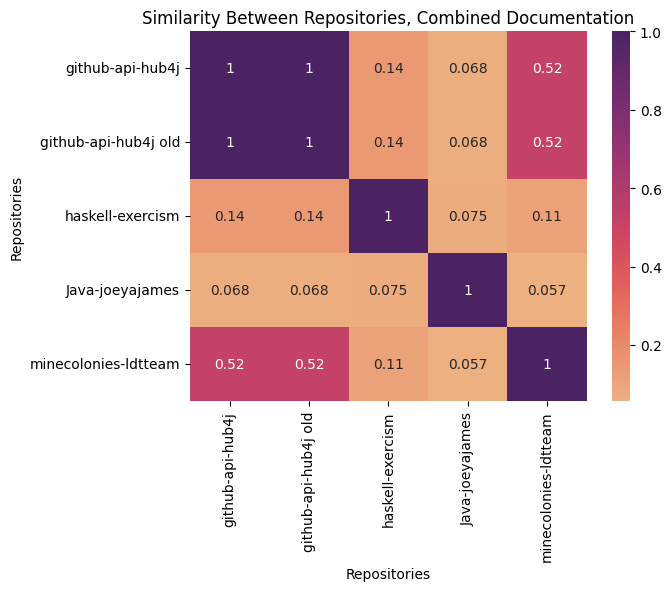

In [189]:
similarity_types = [similarities_readme, similarities_wiki, similarities_comments, similarities_combined]
title = ["Readme Only", "Wiki Only", "Comments Only", "Combined Documentation"]

for index, sim in enumerate(similarity_types):
    sns.heatmap(sim, annot=True, cmap="flare", xticklabels=files_dictionary.keys(), yticklabels=files_dictionary.keys())
    plt.title('Similarity Between Repositories, ' + title[index])
    plt.xlabel('Repositories')
    plt.ylabel('Repositories')
    plt.show()


## Network graph

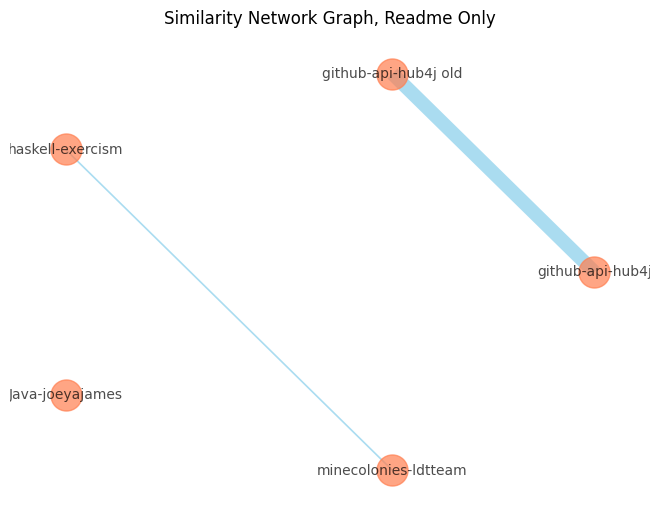

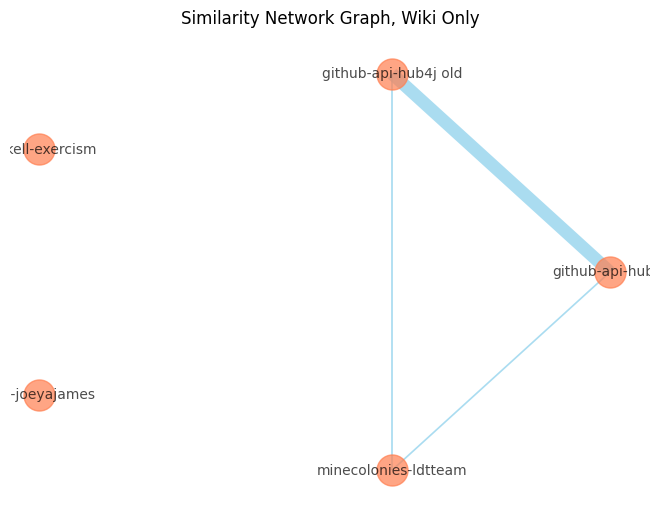

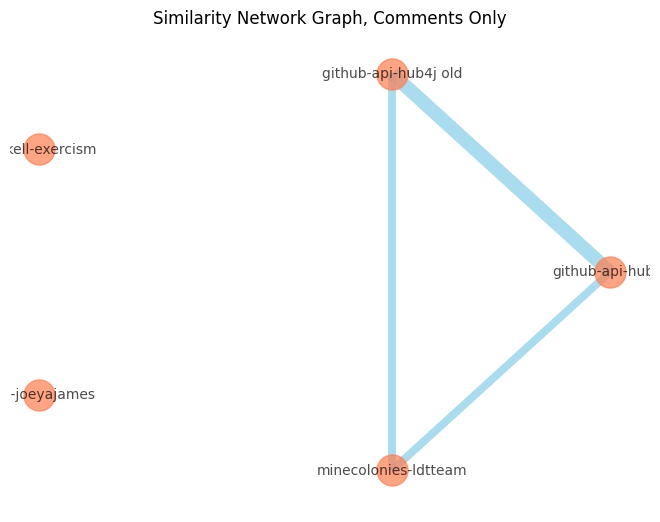

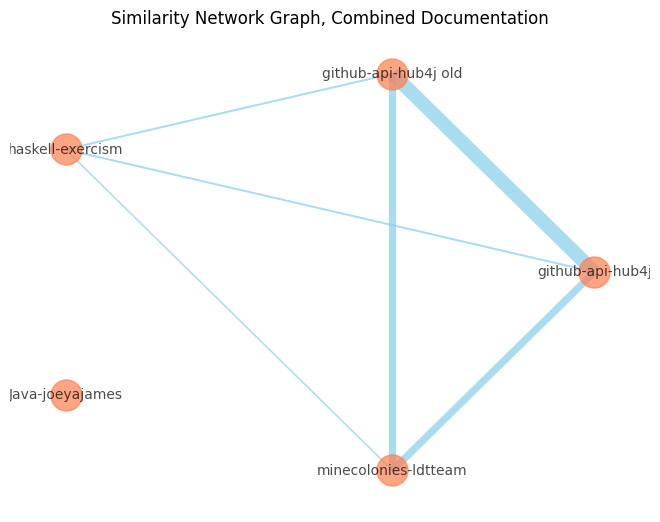

In [190]:
import networkx as nx

for index, sim in enumerate(similarity_types):


    G = nx.Graph()

    for directory in files_dictionary.keys():
        G.add_node(directory)

    threshold = 0.1
    for i in range(num_docs_combined):
        for j in range(i+1, num_docs_combined):
            if sim[i][j] > threshold:
                G.add_edge(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], weight=sim[i][j])

    # pos = nx.spring_layout(G)  
    # pos = nx.shell_layout(G)
    # pox = nx.kamada_kawai_layout(G)
    pos = nx.circular_layout(G)

    edge_widths = [d['weight'] * 10 for (u, v, d) in G.edges(data=True)]

    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, edge_color='skyblue', node_color = 'coral', width=edge_widths, alpha=0.7, style='solid')
    plt.title('Similarity Network Graph, ' + title[index] )
    plt.show()